In [1]:
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch
import os
from jiwer import wer, mer, wil
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns

In [2]:

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You sho

In [3]:
timit_path = r"timit\data\TRAIN\DR1\FCJF0"
audio_file = os.path.join(timit_path, "SA1.WAV")

waveform, sample_rate = torchaudio.load(audio_file)
waveform = waveform.squeeze()

if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)


In [4]:
inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
input_values = inputs.input_values

with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
predicted_text = processor.batch_decode(predicted_ids)[0]
print("Predicted Text:", predicted_text)


Predicted Text: SHE HAD YOUR DUCK SUP AND GREASY WASHWATER ALL YEAR


In [5]:
ground_truth_text = "She had your dark suit in greasy wash water all year"

error_rate = wer(ground_truth_text.lower(), predicted_text.lower())
print("Word Error Rate:", error_rate)

match_error_rate = mer(ground_truth_text.lower(), predicted_text.lower())
wil_rate = wil(ground_truth_text.lower(), predicted_text.lower())
print("Match Error Rate:", match_error_rate)
print("Word Information Lost Rate:", wil_rate)


Word Error Rate: 0.45454545454545453
Match Error Rate: 0.45454545454545453
Word Information Lost Rate: 0.6727272727272728


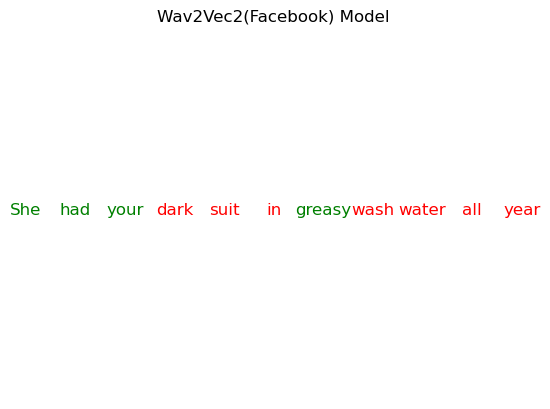

In [6]:
def visualize_pronunciation(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    
    fig, ax = plt.subplots()
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(idx * 0.1, 0.5, word, color=color, fontsize=12, ha='center')
    ax.axis('off')
    ax.set_title('Wav2Vec2(Facebook) Model')
    plt.show()

visualize_pronunciation(ground_truth_text, predicted_text)


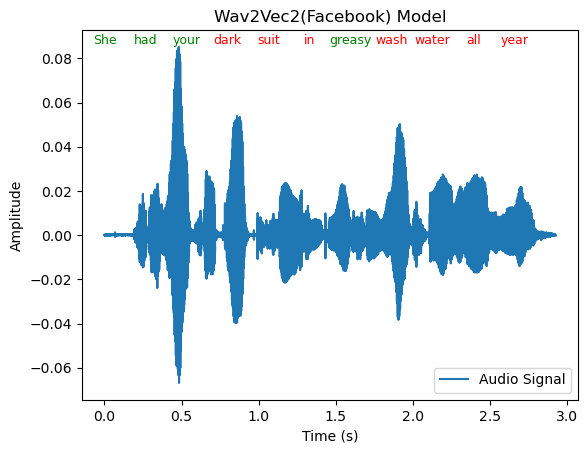

In [7]:
def visualize_audio_with_text_overlay(waveform, ground_truth, prediction, sample_rate=16000):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()

    total_time = waveform.size(0) / sample_rate
    word_times = np.linspace(0, total_time, len(ground_truth_words) + 1)

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, total_time, waveform.size(0)), waveform.numpy(), label="Audio Signal")
    
    for idx, word in enumerate(ground_truth_words):
        color = 'green' if idx < len(predicted_words) and word.lower() == predicted_words[idx].lower() else 'red'
        ax.text(word_times[idx], waveform.max(), word, color=color, fontsize=9, ha='center', va='bottom')
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title('Wav2Vec2(Facebook) Model')
    plt.legend()
    plt.show()

visualize_audio_with_text_overlay(waveform, ground_truth_text, predicted_text)


In [8]:
def get_labels(ground_truth, prediction):
    ground_truth_words = ground_truth.split()
    predicted_words = prediction.split()
    labels = [1 if gt.lower() == pd.lower() else 0 for gt, pd in zip(ground_truth_words, predicted_words)]
    return labels

labels = get_labels(ground_truth_text, predicted_text)

accuracy = accuracy_score([1]*len(labels), labels)
precision = precision_score([1]*len(labels), labels)
recall = recall_score([1]*len(labels), labels)
f1 = f1_score([1]*len(labels), labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.40
Precision: 1.00
Recall: 0.40
F1 Score: 0.57


C:\Users\51man\AppData\Local\Temp\ipykernel_28316\1400842460.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")


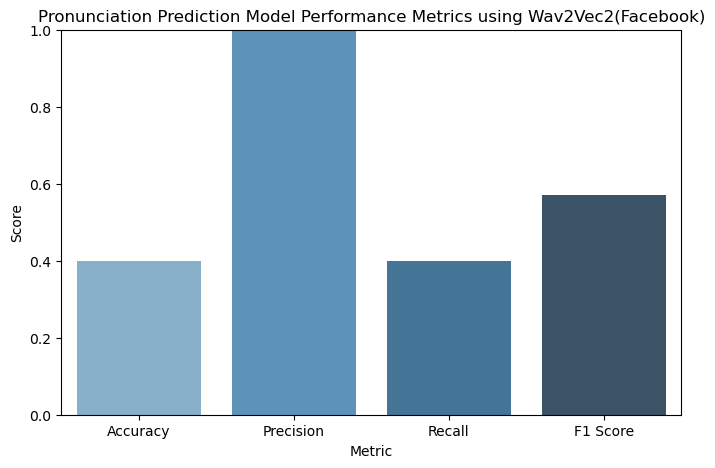

In [9]:
def plot_performance_metrics(accuracy, precision, recall, f1):
    metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_d")
    plt.ylim(0, 1)
    plt.title("Pronunciation Prediction Model Performance Metrics using Wav2Vec2(Facebook)")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.show()

plot_performance_metrics(accuracy, precision, recall, f1)